# Anticipez les besoins en consommation de bâtiments - *Notebook exploratoire*

## Mission

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :


1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

## Analyse exploratoire des datasets et 1er feature engineering

### 1 - Découverte du jeu de données

In [561]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
# Encodage des variables catégorielles avant d'utiliser KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import dummy
from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC

from sklearn import kernel_ridge

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)
print("tensorflow version", tensorflow.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
tensorflow version 2.18.0


In [5]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
data.shape

(3376, 46)

In [7]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


On voit déjà des valeurs aberrantes. Par exemple les valeurs de SourceEUIWN(kBtu/sf) et Electricity(kWh) sont négatives.

In [9]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


OSEBuildingID                        0.00
PropertyGFABuilding(s)               0.00
PropertyGFAParking                   0.00
PropertyGFATotal                     0.00
NumberofFloors                       0.00
YearBuilt                            0.00
Longitude                            0.00
Latitude                             0.00
Neighborhood                         0.00
DefaultData                          0.00
CouncilDistrictCode                  0.00
ComplianceStatus                     0.00
State                                0.00
City                                 0.00
Address                              0.00
PropertyName                         0.00
PrimaryPropertyType                  0.00
BuildingType                         0.00
DataYear                             0.00
TaxParcelIdentificationNumber        0.00
SiteEnergyUse(kBtu)                  0.15
SiteEnergyUseWN(kBtu)                0.18
SiteEUIWN(kBtu/sf)                   0.18
SiteEUI(kBtu/sf)                  

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Pour rappel, il y a 3 376 lignes.

In [12]:
list_sort = round((data == 0).mean().sort_values() * 100, 2)
print('Pourcentage de valeurs = 0 par colonne')
list_sort

Pourcentage de valeurs = 0 par colonne


OSEBuildingID                       0.00
Outlier                             0.00
ComplianceStatus                    0.00
Comments                            0.00
ENERGYSTARScore                     0.00
YearsENERGYSTARCertified            0.00
ThirdLargestPropertyUseType         0.00
SecondLargestPropertyUseType        0.00
LargestPropertyUseType              0.00
ListOfAllPropertyUseTypes           0.00
PropertyGFABuilding(s)              0.00
PropertyGFATotal                    0.00
YearBuilt                           0.00
LargestPropertyUseTypeGFA           0.00
Latitude                            0.00
DataYear                            0.00
BuildingType                        0.00
Neighborhood                        0.00
PrimaryPropertyType                 0.00
CouncilDistrictCode                 0.00
TaxParcelIdentificationNumber       0.00
ZipCode                             0.00
State                               0.00
Longitude                           0.00
City            

In [13]:
list_sort = (data == 0).sum().sort_values()
print('Nombres de valeurs = 0 par colonne')
list_sort

Nombres de valeurs = 0 par colonne


OSEBuildingID                         0
Outlier                               0
ComplianceStatus                      0
Comments                              0
ENERGYSTARScore                       0
YearsENERGYSTARCertified              0
ThirdLargestPropertyUseType           0
SecondLargestPropertyUseType          0
LargestPropertyUseType                0
ListOfAllPropertyUseTypes             0
PropertyGFABuilding(s)                0
PropertyGFATotal                      0
YearBuilt                             0
LargestPropertyUseTypeGFA             0
Latitude                              0
DataYear                              0
BuildingType                          0
Neighborhood                          0
PrimaryPropertyType                   0
CouncilDistrictCode                   0
TaxParcelIdentificationNumber         0
ZipCode                               0
State                                 0
Longitude                             0
City                                  0


In [14]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [15]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [16]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [17]:
data['CouncilDistrictCode'].unique()

array([7, 3, 2, 4, 5, 6, 1], dtype=int64)

In [18]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [19]:
data['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'Other - Mall', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Distribution Center', 'Parking', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient', nan,
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Indust

In [20]:
data['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [21]:
mask = (data['Outlier'] == 'High outlier') | (data['Outlier'] == 'Low outlier')
print("Nombre de propriétés aberrantes : ", data.loc[mask].shape[0])

Nombre de propriétés aberrantes :  32


In [22]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [23]:
mask = data['ComplianceStatus'].isin(['Non-Compliant'])
print("Nombre de propriétés not compliant :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Missing Data'])
print("Nombre de propriétés missing-data :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Error - Correct Default Data'])
print("Nombre de propriétés error :", data.loc[mask].shape[0])

Nombre de propriétés not compliant : 37
Nombre de propriétés missing-data : 15
Nombre de propriétés error : 113


On constate:
- Il n'y a qu'une seule année dans le dataset
- Il y a 8 types d'immmeuble (BuildingType)
- Il y a une seule ville : Seattle, dans un seul état
- Il y a 7 districts différents (CouncilDistrictCode)
- Il y a 19 quartiers (Neighborhood), mais certains sont en double, donc 13 réels (nettoyage à prévoir)
- Il y a 55 codes postaux différents (ZipCode)
- Il y a 113 années de construction différentes (yearBuilt)
- Il y a 100 valeurs différentes pour l'ENERGYSTARScore
- Plusieurs batiments ont la même consommation d'energie, et le même taux d'émission de COS
- Quelques bâtiments ont la même adresse
- La feature 'Outlier' ne contient que 2 valeurs : High outlier et Low outlier. Et 99% des valeurs sont manquantes. Elle n'est donc pas utlisable
- La feature 'ComplianceStatus' contient 4 valeurs : Compliant', 'Error - Correct Default Data', 'Missing Data', et 'Non-Compliant'. Toutes les valeurs sont présentes.

In [25]:
data.duplicated().sum()

0

Il n'y a pas de données dupliquées.

### 2 - Choix des variables

#### 2.1 - Sources d'energie

Il y a 3 sources d'energie dans le fichier : electricité, vapeur, gaz naturel.

Il faut choisir les sources exprimées en kBtu pour pouvoir les comparer entre elles, et déterminer la proportion utilisée par bâtiment.

Il s'agit des variables : Electricity(kBtu) , NaturalGas(kBtu), SteamUse(kBtu) 

Ces 3 variables sont assez bien utilisées.

#### 2.2 - Données structurelles

Liste des données structurelles
- PrimaryPropertyType (usage principal)
- Neighborhood (quartier)
- YearBuilt (année de construction) - créer des périodes (nouvelle variable catégorielle)
- NumberofBuildings (nombre de bâtiments)
- NumberofFloors (nombre d'étages)
- PropertyGFATotal (surface plancher brute bâtiment et stationnement)
- PropertyGFAParking (surface totale des stationnements en pieds carrés)  - dans un second temps pour l'amélioration des modèles
- PropertyGFABuilding(s) (surface des bâtiments hors stationnement en pieds carrés)  - dans un second temps pour l'amélioration des modèles
- LargestPropertyUseType (doublon avec PrimaryPropertyType ???)  - dans un second temps pour l'amélioration des modèles
- LargestPropertyUseTypeGFA (surface d'utlisation du type d'usage principal)  - dans un second temps pour l'amélioration des modèles

SecondLargestPropertyUseType et ThirdLargestPropertyUseType ne sont pas suffisamment valorisées, respectivement 50% et 82% de valeurs manquantes.

#### 2.3 - Choix des 2 variables cibles


Le dataset ne contient pas la superficie des bâtiments : faut-il donner les cibles en valeur absolue ? Ou divisée par la superficie ?


**Consommation totale d’énergie**

Il y a plusieurs features qui pourraient représenter la consommation totale d'energy. Mais la plus pertinente est 'SiteEnergyUseWN(kBtu)', car :
- Elle est très bien valorisée (0,18 % de valeurs manquantes)
- Elle intègre toutes les sources d'energy
- Elle est harmonisée
- Sa valeur n'est pas déterminée en fonction de la superficie du bâtiment

**émissions de CO2**

Il y a plusieurs features qui pourraient représenter les émissions de CO2. Mais la plus pertinente est 'TotalGHGEmissions', car :
- Elle est très bien valorisée (0,27 % de valeurs manquantes)
- Sa valeur n'est pas déterminée en fonction de la superficie du bâtiment

#### 2.4 - ENERGYSTARScore

Il est assez mal valorisé. Il s'agit d'une note de 1 à 100 calculée, qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations et les opérations du bâtiment. Un score de 50 représente la médiane nationale.

### 3 - Filter le dataset sur les bâtiments non destinés à l'habitation

La variable qui permet d'identifier le caractère résidentiel ou non est "BuildingType". Elle prend les valeurs suivantes :

In [34]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Si on demande à ChatGPT de décrire ces types, voici ce qu'on obtient :

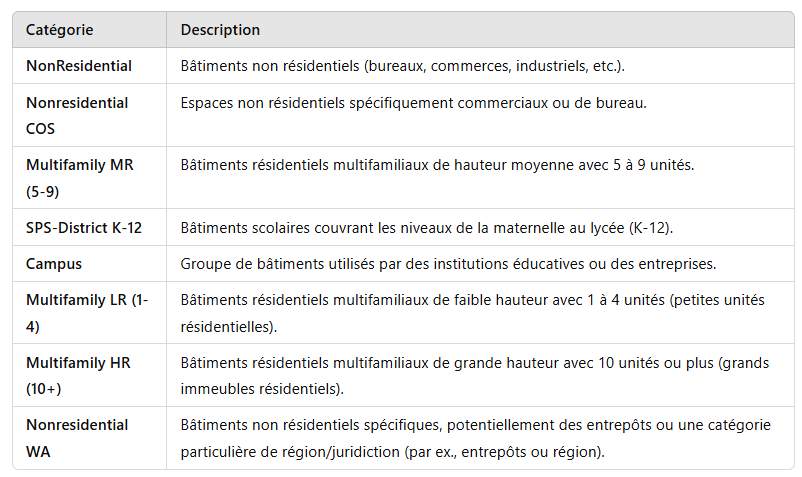

Pour le projet, nous allons donc retenir les catégories suivantes :
- NonResidential
- Nonresidential COS
- SPS-District K-12
- Campus
- Nonresidential WA

In [38]:
building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

In [39]:
mask = data['BuildingType'].isin(building_types)
data = data.loc[mask]
data.shape

(1668, 46)

Il reste la moitié des bâtiments dans le dataset.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1668 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   Address                          1668 non-null   object 
 6   City                             1668 non-null   object 
 7   State                            1668 non-null   object 
 8   ZipCode                          1652 non-null   float64
 9   TaxParcelIdentificationNumber    1668 non-null   object 
 10  CouncilDistrictCode              1668 non-null   int64  
 11  Neighborhood                     1668 non-null   object 
 12  Latitude                 

### 4 - Supprimer les produits qui n'ont pas de valeurs cibles

In [43]:
cibles = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [44]:
data.shape

(1668, 46)

**Rechercher et supprimer les valeurs manquantes**

In [46]:
mask = data['SiteEnergyUseWN(kBtu)'].isna()
print(data.loc[mask, ['PropertyName', 'SiteEnergyUseWN(kBtu)']])

                                 PropertyName  SiteEnergyUseWN(kBtu)
563   Market Place I & II-2003 Western Avenue                    NaN
578                          SEATTLE BUILDING                    NaN
2670                         KALBERG BUILDING                    NaN


In [47]:
mask = ~data['SiteEnergyUseWN(kBtu)'].isna()
data = data.loc[mask]

In [48]:
data.shape

(1665, 46)

In [49]:
mask = data['TotalGHGEmissions'].isna()
print(data.loc[mask, ['PropertyName', 'TotalGHGEmissions']])

Empty DataFrame
Columns: [PropertyName, TotalGHGEmissions]
Index: []


Les valeurs de la variable TotalGHGEmissions des lignes supprimées étaient aussi manquantes

**Rechercher et supprimer les valeurs nulles qui sont à considérer comme manquante**

In [52]:
mask = data['SiteEnergyUseWN(kBtu)'] == 0
print(data.loc[mask, ['PropertyName', 'SiteEnergyUseWN(kBtu)']])

                                     PropertyName  SiteEnergyUseWN(kBtu)
28                                 Meany Building                    0.0
31                            John Hay Elementary                    0.0
62                       Arbor Heights Elementary                    0.0
81                                 Pathfinder K-8                    0.0
85                           John Muir Elementary                    0.0
95                            B.F. Day Elementary                    0.0
133                                Whitman Middle                    0.0
139                             Washington Middle                    0.0
152                       Olympic View Elementary                    0.0
220                               Norton Building                    0.0
247                        Metropolitan Park East                    0.0
284               Onni 1411 Fourth Development LP                    0.0
304            Washington State Convention Center  

In [53]:
mask = ~(data['SiteEnergyUseWN(kBtu)'] == 0)
data = data.loc[mask]

In [54]:
data.shape

(1640, 46)

In [55]:
mask = data['TotalGHGEmissions'] == 0
print(data.loc[mask, ['PropertyName', 'TotalGHGEmissions']])

                  PropertyName  TotalGHGEmissions
513  IUC- Whole Foods Interbay                0.0


In [56]:
mask = ~(data['TotalGHGEmissions'] == 0)
data = data.loc[mask]

In [57]:
data.shape

(1639, 46)

### 5 - Automatiser les étapes 3 et 4

In [59]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.shape

(3376, 46)

In [60]:
def select_dataset(df):

    # Filter le dataset sur les bâtiments non destinés à l'habitation
    building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']
    mask = df['BuildingType'].isin(building_types)
    df = df.loc[mask]
    
    # Supprimer les produits qui n'ont pas de valeurs cibles
    ## Rechercher et supprimer les valeurs manquantes
    mask = ~df['SiteEnergyUseWN(kBtu)'].isna()
    df = df.loc[mask]
    mask = ~df['TotalGHGEmissions'].isna()
    df = df.loc[mask]

    ## Rechercher et supprimer les valeurs nulles qui sont à considérer comme manquantes
    mask = (df['SiteEnergyUseWN(kBtu)'] != 0) & (df['TotalGHGEmissions'] != 0)
    df = df.loc[mask]

    return df    

In [61]:
data = select_dataset(data)
data.shape

(1639, 46)

### 6 - 1er feature engineering

#### 6.1 - Traiter les valeurs manquantes des features de consommation d'energy

In [64]:
mask = (data['Electricity(kBtu)'] == 0) & (data['NaturalGas(kBtu)'] == 0) & (data['SteamUse(kBtu)'] == 0)
print("Nombre de lignes où les valeurs des 3 types d'energy sont nulles : ", data.loc[mask].shape[0])

Nombre de lignes où les valeurs des 3 types d'energy sont nulles :  0


In [65]:
mask = (data['Electricity(kBtu)'].isna()) & (data['NaturalGas(kBtu)'].isna()) & (data['SteamUse(kBtu)'].isna())
print("Nombre de lignes où les valeurs des 3 types d'energy sont manquantes : ", data.loc[mask].shape[0])

Nombre de lignes où les valeurs des 3 types d'energy sont manquantes :  0


Il n'y a pas de données à supprimer ici.

#### 6.2 - Filtrer sur les variables "Outlier" et "CompliantStatus"

In [68]:
mask = (data['Outlier'] == 'High outlier') | (data['Outlier'] == 'Low outlier')
print("Nombre de propriétés aberrantes : ", data.loc[mask].shape[0])

Nombre de propriétés aberrantes :  17


Comme le nombre de propriété aberrantes concerne 1% du dataset, on peut supprimer ces lignes:

In [70]:
data.shape

(1639, 46)

In [71]:
mask = ~data['Outlier'].isin(['High outlier', 'Low outlier'])
data = data.loc[mask]
data.shape

(1622, 46)

In [72]:
mask = data['ComplianceStatus'].isin(['Non-Compliant'])
print("Nombre de propriétés not compliant :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Missing Data'])
print("Nombre de propriétés missing-data :", data.loc[mask].shape[0])

mask = data['ComplianceStatus'].isin(['Error - Correct Default Data'])
print("Nombre de propriétés error :", data.loc[mask].shape[0])

Nombre de propriétés not compliant : 0
Nombre de propriétés missing-data : 0
Nombre de propriétés error : 85


Les 85 propriétés en erreur représentent 5% du dataset. Cela fait beaucoup à supprimer. Donc pour le moment je les conserve pour le 1er feature engineering, car la description de cette variable n'est pas claire sur ce type d'erreur. Peut-être qu'on les supprimera ensuite pour améliorer le modèle.

**Automatisation:**

In [75]:
def delete_outliers(df):
    mask = ~df['Outlier'].isin(['High outlier', 'Low outlier'])
    df= df.loc[mask]
    return df

#### 6.3 - Nettoyer les données de la variable cible SiteEnergyUseWN(kBtu)

Liste des variables du 1er feature engineering :

In [455]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

**Traiter les valeurs aberrantes**

In [80]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1622.000000,1622.000000,1622.000000,1.622000e+03,1.622000e+03,1.622000e+03,1.622000e+03,1.622000e+03,1622.000000
mean,1962.048089,1.102959,4.136868,1.132678e+05,5.494045e+06,2.012954e+06,4.655916e+05,8.219665e+06,181.147244
std,32.689652,1.170743,6.620385,1.934086e+05,1.342554e+07,9.491907e+06,5.171827e+06,2.227302e+07,711.156893
min,1900.000000,0.000000,0.000000,1.128500e+04,-1.154170e+05,0.000000e+00,0.000000e+00,5.811420e+04,-0.800000
25%,1930.000000,1.000000,1.000000,2.939250e+04,7.418918e+05,0.000000e+00,0.000000e+00,1.362387e+06,20.870000
50%,1965.500000,1.000000,2.000000,4.898850e+04,1.633988e+06,5.313785e+05,0.000000e+00,2.772078e+06,50.245000
75%,1989.000000,1.000000,4.000000,1.046775e+05,4.902622e+06,1.531840e+06,0.000000e+00,7.322608e+06,143.102500
max,2015.000000,27.000000,99.000000,2.200000e+06,2.745325e+08,2.979090e+08,1.349435e+08,4.716139e+08,16870.980000


Visualiser la distribution:

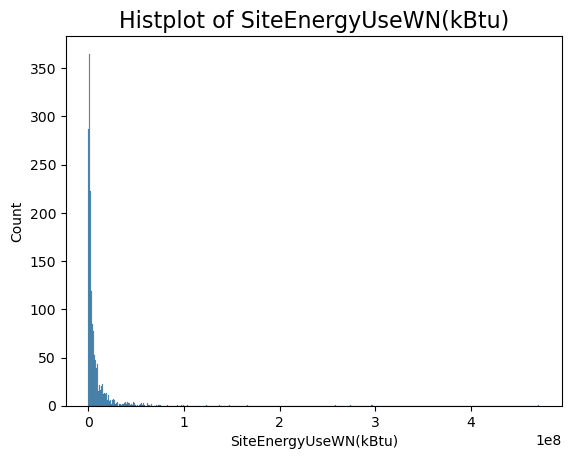

In [82]:
#plt.figure(figsize=(15,5))
sns.histplot(data=data, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

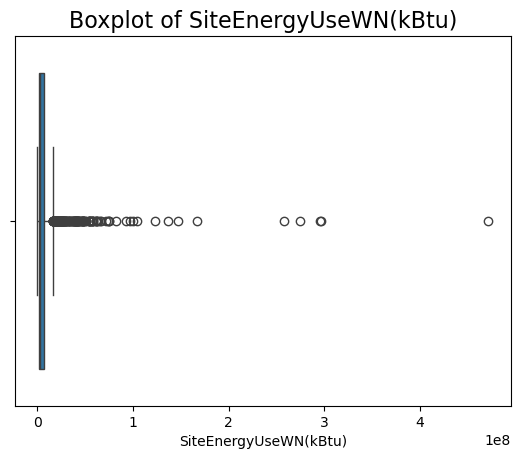

In [83]:
sns.boxplot(x=data['SiteEnergyUseWN(kBtu)'])
plt.title('Boxplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

On constate la présence de nombreux outliers qui viennent perturber la visualisation.

On peut aussi regarder la méthode basée sur l'IQR pour idnetifier les valeurs aberrantes. L'IQR est la différence entre le 25e centile (Q1) et le 75e centile (Q3) des données. Les valeurs :

inférieures à Q1 - 1,5 * IQR
ou supérieures à Q3 + 1,5 * IQR
sont considérées comme aberrantes.

In [85]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['SiteEnergyUseWN(kBtu)'].quantile(0.25)
Q3 = data['SiteEnergyUseWN(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kBtu")
print("limite haute :", round(limite_haute,2), "kBtu")

limite basse : 0 kBtu
limite haute : 16262938.3 kBtu


Combien de propriétés sont au-dessus de la limite haute ?

In [87]:
mask = data['SiteEnergyUseWN(kBtu)'] > limite_haute
print("Nombre de propriétés au-dessus de la limite haute :", data.loc[mask].shape[0])

Nombre de propriétés au-dessus de la limite haute : 177


Quel est le "complianceStatus" de ces propriétés ?

In [89]:
data.loc[mask, 'ComplianceStatus'].value_counts()

ComplianceStatus
Compliant    177
Name: count, dtype: int64

On voit ici la faible utilité de la variable ComplianceStatus

Quelle est la distribution sans ces propriétés ?

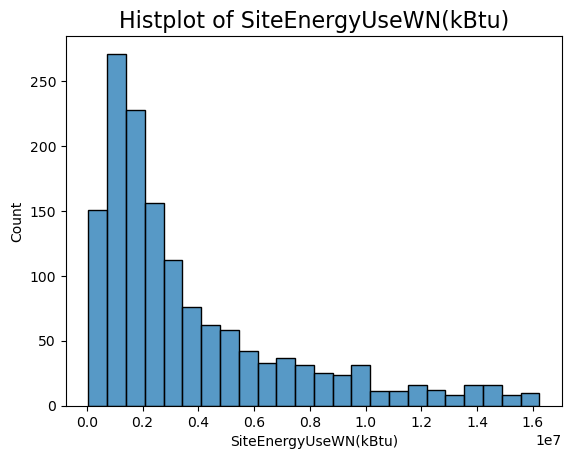

In [92]:
mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
sample = data.loc[mask]
sns.histplot(data=sample, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

On visualise une distribution unimodale asymétrique (étalement à droite).

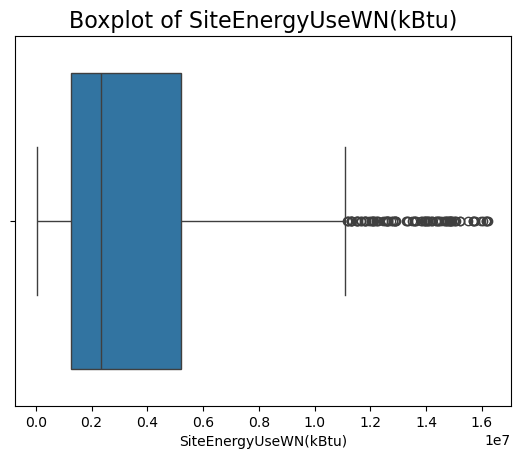

In [94]:
sns.boxplot(x=sample['SiteEnergyUseWN(kBtu)'])
plt.title('Boxplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

Est-ce que ces valeurs "aberrantes" ont un lien avec la surface du bâtiment ?

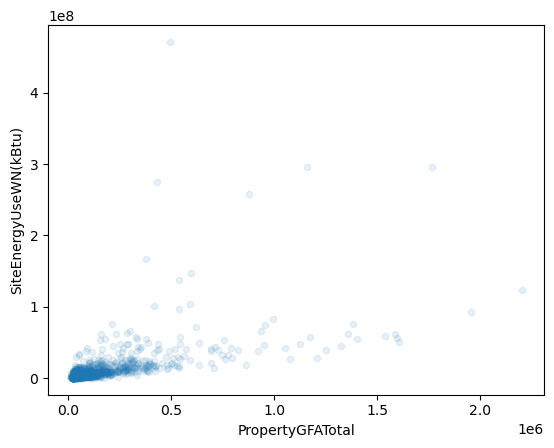

In [96]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

On voit ici que les valeurs de consommation au-dessus de 1,6e8 ne s'expliquent pas forcément par la superficie du bâtiment.

Je vais donc supprimer du dataset les valeurs au-dessus de la limite haute.

In [98]:
mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
data = data.loc[mask]

In [99]:
data.shape

(1445, 46)

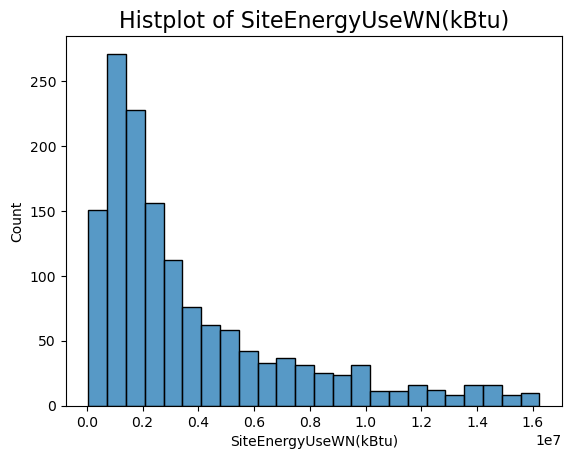

In [100]:
sns.histplot(data=sample, x='SiteEnergyUseWN(kBtu)')
plt.title('Histplot of SiteEnergyUseWN(kBtu)', fontsize=16)
plt.show()

**Traiter les données manquantes**

Identifier les valeurs NaN :

In [102]:
mask = data['SiteEnergyUseWN(kBtu)'].isna()
print("Nombre de propriétés dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est manquante : 0


Identifier les valeurs nulles :

In [104]:
mask = data['SiteEnergyUseWN(kBtu)'] == 0
print("Nombre de propriétés dont la valeur est nulle :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est nulle : 0


In [105]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1445.000000,1445.000000,1445.000000,1445.000000,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1445.000000
mean,1960.210381,1.022145,3.078201,69280.738408,2.492841e+06,1.018276e+06,9.451563e+04,3.767918e+06,78.754754
std,32.678129,0.435040,3.746112,70740.623113,2.744288e+06,1.505151e+06,5.616864e+05,3.595049e+06,95.616344
min,1900.000000,0.000000,0.000000,11285.000000,-1.154170e+05,0.000000e+00,0.000000e+00,5.811420e+04,-0.800000
25%,1929.000000,1.000000,1.000000,28072.000000,6.781670e+05,0.000000e+00,0.000000e+00,1.259282e+06,18.620000
50%,1963.000000,1.000000,2.000000,43661.000000,1.357120e+06,4.768320e+05,0.000000e+00,2.340056e+06,43.450000
75%,1987.000000,1.000000,4.000000,78374.000000,3.327045e+06,1.239357e+06,0.000000e+00,5.205994e+06,95.860000
max,2015.000000,6.000000,99.000000,706176.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.4 - Nettoyer les données de la variable cible TotalGHGEmissions

**Traiter les valeurs aberrantes**

On voit qu'il y a des valeurs négatives, ce qui est aberrant ici.

On supprime les valeurs négatives :

In [108]:
mask = data['TotalGHGEmissions'] >= 0
print("Nombre de valeurs négatives :", data.shape[0] - data.loc[mask].shape[0])
data = data.loc[mask]

Nombre de valeurs négatives : 1


In [109]:
data.shape

(1444, 46)

In [110]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.022161,3.076177,69292.705679,2.494647e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.435190,3.746620,70763.667283,2.744379e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,0.000000,0.000000,11285.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.783500e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.357482e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,706176.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


Visualiser la distribution :

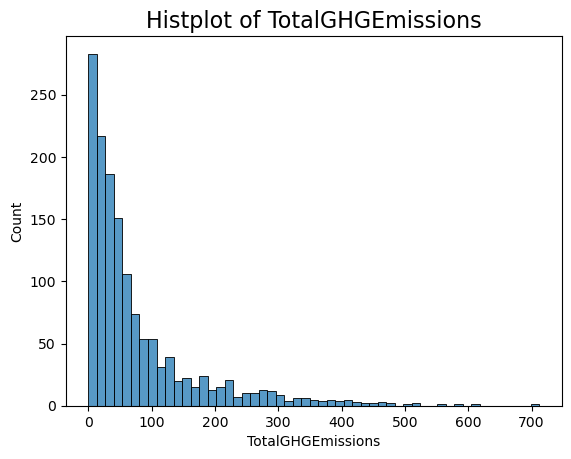

In [112]:
sns.histplot(data=data, x='TotalGHGEmissions')
plt.title('Histplot of TotalGHGEmissions', fontsize=16)
plt.show()

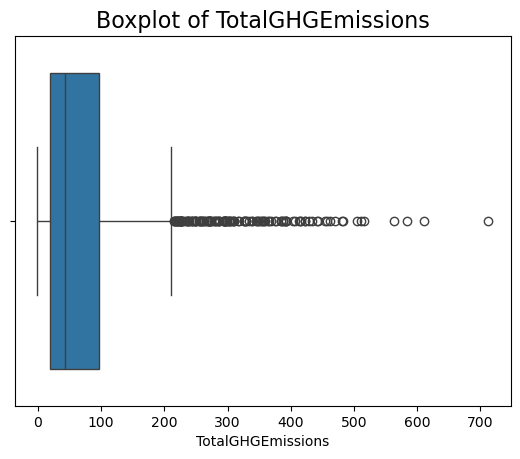

In [113]:
sns.boxplot(x=sample['TotalGHGEmissions'])
plt.title('Boxplot of TotalGHGEmissions', fontsize=16)
plt.show()

Visualiser le lien entre les émissions et la consommation d'energie :

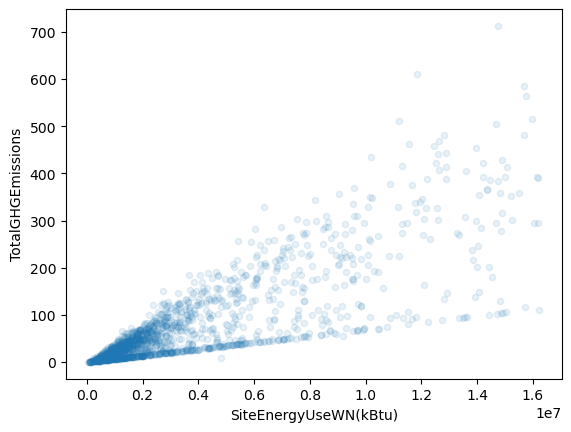

In [115]:
# Création du scatter plot
data.plot.scatter(x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

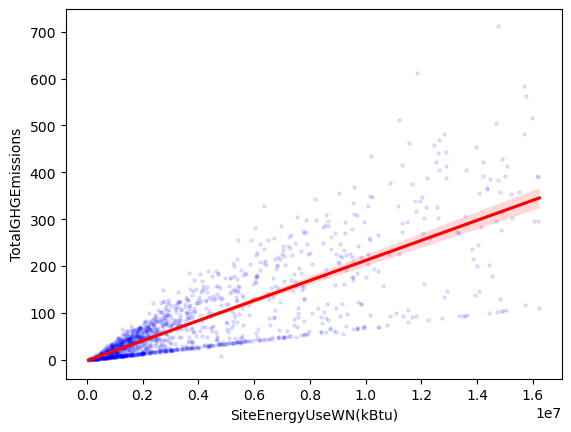

In [116]:
# Afficher le regplot
sns.regplot(x='SiteEnergyUseWN(kBtu)', y='TotalGHGEmissions', data=data, color='blue', marker='o', line_kws={'color': 'red'}, scatter_kws={'s': 5, 'alpha': 0.1})

# Afficher le graphique
plt.show()

Ce diagramme montre clairement une corrélation positive entre la consommation d'énergie sur le site (SiteEnergyUseWN) et les émissions de gaz à effet de serre totales (TotalGHGEmissions). Plus l'utilisation d'énergie est grande, plus les émissions de GES augmentent. Cependant, la dispersion indique que la relation n'est pas parfaitement linéaire et qu'il pourrait y avoir d'autres variables en jeu.

**Traiter les données manquantes**

Identifier les valeurs NaN :

In [119]:
mask = data['TotalGHGEmissions'].isna()
print("Nombre de propriétés dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est manquante : 0


Identifier les valeurs nulles :

In [121]:
mask = data['TotalGHGEmissions'] == 0
print("Nombre de propriétés dont la valeur est nulle :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est nulle : 0


Pas besoin de traiter les valeurs manquantes ou nulles car il n'y en a pas.

In [123]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.022161,3.076177,69292.705679,2.494647e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.435190,3.746620,70763.667283,2.744379e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,0.000000,0.000000,11285.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.783500e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.357482e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,706176.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.5 - Nettoyer la feature YearBuilt

**Traiter les valeurs aberrantes**

Les années de construction s'étalent entre 1900 et 2015.

In [125]:
data['YearBuilt'].dtypes

dtype('int64')

Cette feature est de type entier. Il n'y a donc pas à priori de valeurs aberrantes.

Visualiser la distribution:

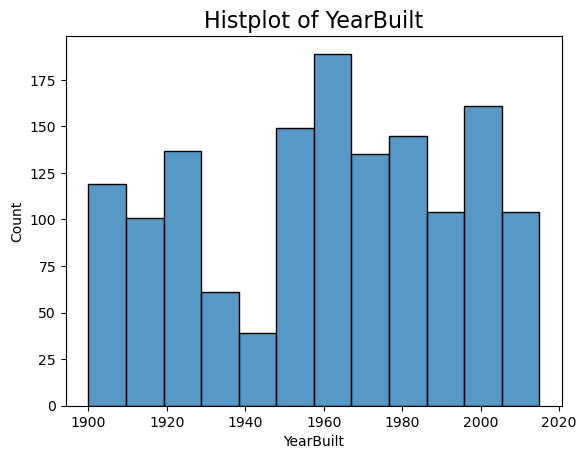

In [127]:
sns.histplot(data=data, x='YearBuilt')
plt.title('Histplot of YearBuilt', fontsize=16)
plt.show()

Visualiser les corrélations avec les cibles :

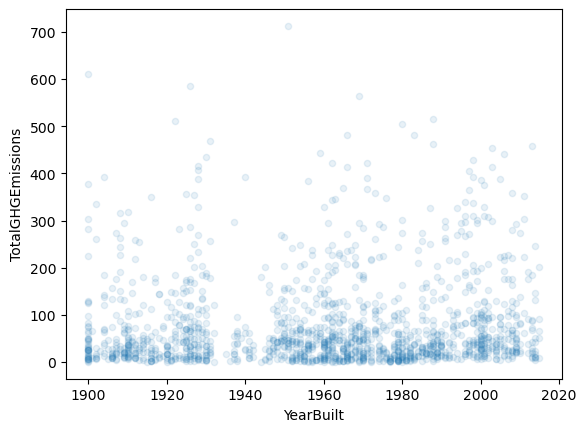

In [129]:
# Création du scatter plot
data.plot.scatter(x='YearBuilt', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

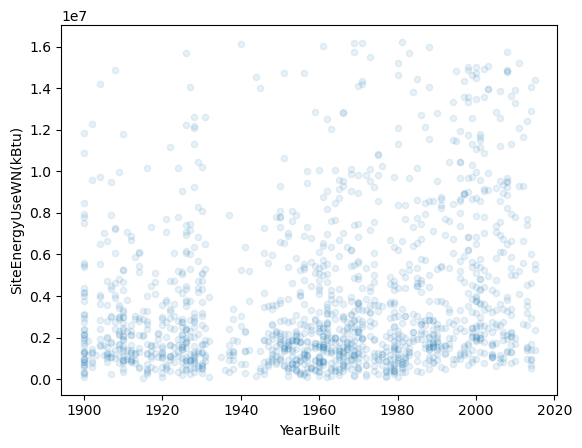

In [130]:
# Création du scatter plot
data.plot.scatter(x='YearBuilt', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes**

Identifier les valeurs manquantes :

In [132]:
mask = data['YearBuilt'].isna()
print("Nombre de propriétés dont la valeur est manquante :", data.loc[mask].shape[0])

Nombre de propriétés dont la valeur est manquante : 0


Pas de données manquantes ici.

#### 6.6 - Nettoyer les données de la feature NumberofBuildings

**Traiter les valeurs aberrantes**

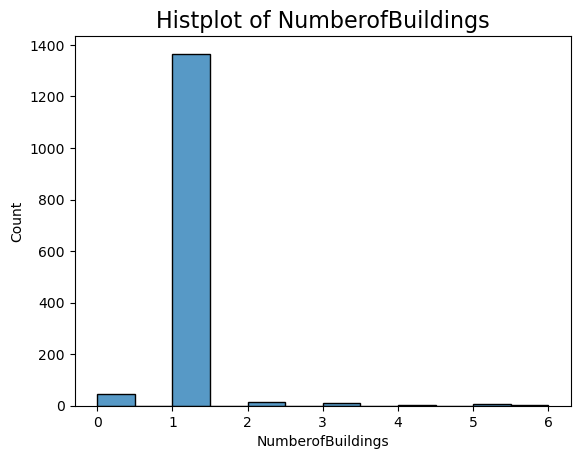

In [135]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

In [136]:
data['NumberofBuildings'].dtypes

dtype('float64')

Certaines valeurs ne sont pas des entiers, ce qui n'est pas normal. 

Rechercher les valeurs qui ne sont pas des entiers :

In [138]:
# Filtrer les valeurs qui ne sont pas des entiers
valeurs_non_entieres = data[~data['NumberofBuildings'].apply(lambda x: isinstance(x, int))]
print(valeurs_non_entieres['NumberofBuildings'])

0       1.0
1       1.0
3       1.0
4       1.0
5       1.0
       ... 
3371    1.0
3372    1.0
3373    1.0
3374    1.0
3375    1.0
Name: NumberofBuildings, Length: 1444, dtype: float64


In [139]:
data['NumberofBuildings'].unique()

array([1., 0., 2., 3., 6., 5., 4.])

Il n'y a que 0 qui est une valeur aberrante, car il devrait y avoir au moins un bâtiment. On va les transformer en NaN.

In [141]:
# remplacer dans le dataset
mask = data['NumberofBuildings'] == 0.
data.loc[mask, 'NumberofBuildings'] = np.nan

In [142]:
data['NumberofBuildings'].unique()

array([ 1., nan,  2.,  3.,  6.,  5.,  4.])

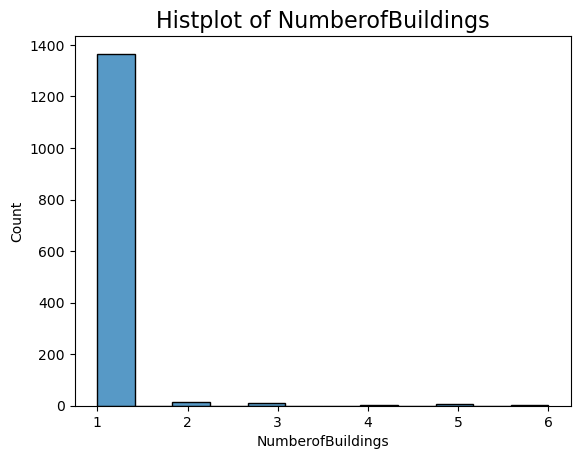

In [143]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

**Traiter les valeurs manquantes**

Nombre de valeurs manquantes :

In [145]:
mask = data['NumberofBuildings'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 44


In [146]:
# Diagramme en secteurs
def build_pieplot(series, variable_label):
    plt.figure(figsize=(6, 6))
    plt.pie(series, 
            labels=series.index, 
            autopct='%1.1f%%',  # Affiche les pourcentages avec 1 décimale
            startangle=140,     # Angle de départ pour la première tranche
            wedgeprops=dict(edgecolor='black'))  # Couleur de la bordure des secteurs
    
    plt.title('Diagramme en secteurs de la variable ' + variable_label, fontsize=16)
    # Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
    plt.axis('equal')
    # Personnaliser la taille des labels des secteurs
    plt.setp(plt.gca().texts, fontsize=12)  # Taille des étiquettes des secteurs
    plt.setp(plt.gca().patches, edgecolor='black')  # Couleur des bordures des secteurs
    
    plt.show()

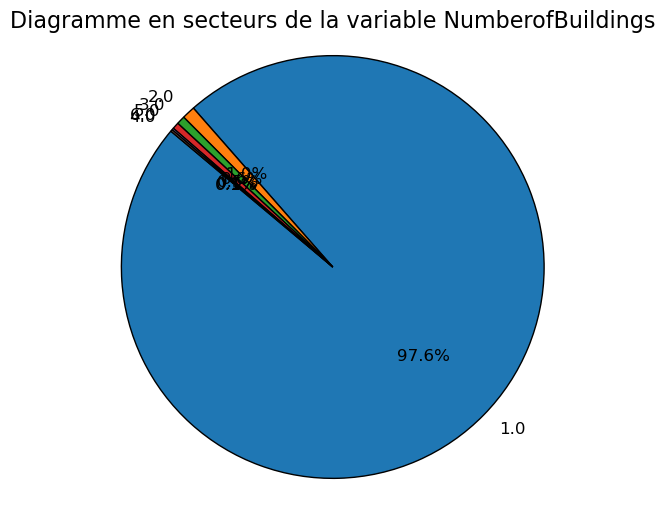

In [147]:
build_pieplot(data['NumberofBuildings'].value_counts(), 'NumberofBuildings')

Le nombre de bâtiment par propriété est 1 pour 97.6%. Je propose donc de remplacer les valeurs manquantes par 1 qui est la valeur majoritaire :

In [149]:
mask = data['NumberofBuildings'].isna()
data.loc[mask, 'NumberofBuildings'] = 1

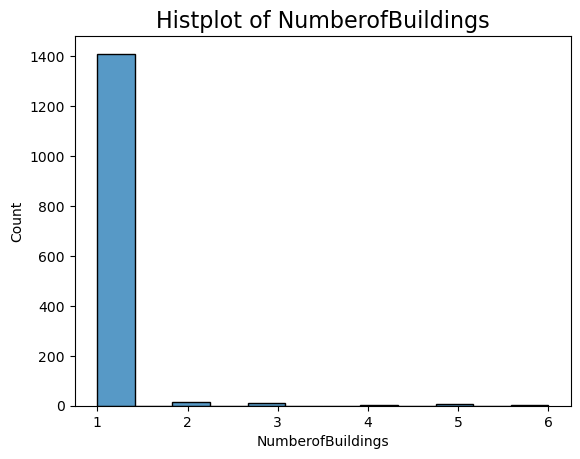

In [150]:
sns.histplot(data=data, x='NumberofBuildings')
plt.title('Histplot of NumberofBuildings', fontsize=16)
plt.show()

La distribution ne change pas beaucoup. Seule la 1er barre est un peu plus haute.

In [152]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,69292.705679,2.494647e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,70763.667283,2.744379e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.783500e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.357482e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,706176.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.7 - Nettoyer les données de la variable NumberofFloors

**Traiter le valeurs aberrantes:**

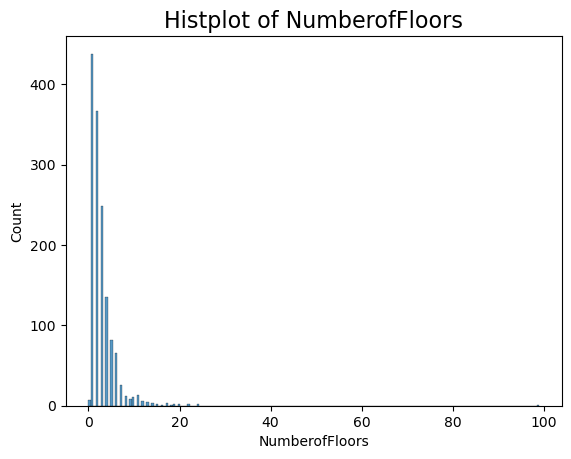

In [154]:
sns.histplot(data=data, x='NumberofFloors')
plt.title('Histplot of NumberofFloors', fontsize=16)
plt.show()

In [155]:
data['NumberofFloors'].dtypes

dtype('int64')

Il n'y a pas de valeurs aberrantes à priori. 0 n'est pas une valeur aberrante, car un bâtiment de plein pieds n'a pas d'étage.

**Traiter les valeurs manquantes:**

In [158]:
mask = data['NumberofFloors'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y pas de valeurs manquantes.

In [160]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,69292.705679,2.494647e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,70763.667283,2.744379e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.783500e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.357482e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,706176.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.8 - Nettoyer les données de la feature PropertyGFATotal

**Traiter les valeurs aberrantes:**

Visualiser la distribution:

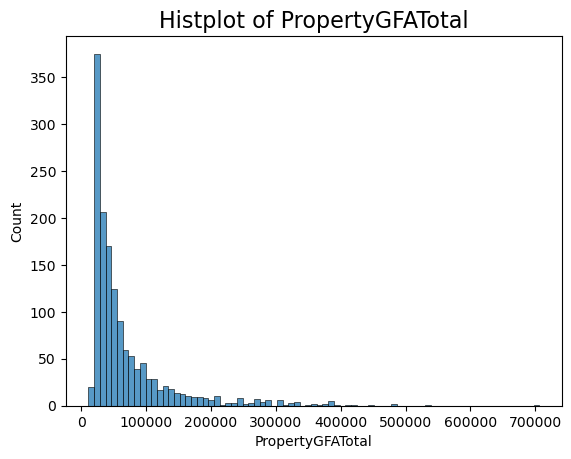

In [162]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

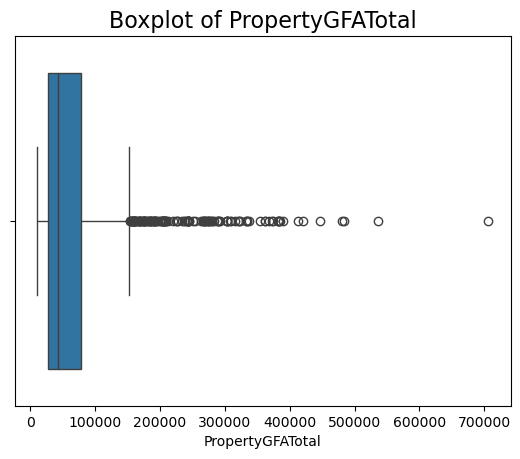

In [163]:
sns.boxplot(x=sample['PropertyGFATotal'])
plt.title('Boxplot of PropertyGFATotal', fontsize=16)
plt.show()

Rechercher les outliers par la méthode de l'IQR:

In [165]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['PropertyGFATotal'].quantile(0.25)
Q3 = data['PropertyGFATotal'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "pieds carrés")
print("limite haute :", round(limite_haute,2), "pieds carrés")

limite basse : 0 pieds carrés
limite haute : 153858.88 pieds carrés


Combien de propriétés sont au-dessus de la limite haute :

In [167]:
mask = data['PropertyGFATotal'] > limite_haute
print("Nombre de propriétés au-dessus de la limite haute :", data.loc[mask].shape[0])

Nombre de propriétés au-dessus de la limite haute : 134


Font-ils partis des erreurs dans le complianceStatus ?

In [169]:
mask = (data['PropertyGFATotal'] > limite_haute) & (data['ComplianceStatus'] == 'Error - Correct Default Data')
print("Nombre de propriétés au-dessus de la limite haute et en erreur sur le complianceStatus:", data.loc[mask].shape[0])

Nombre de propriétés au-dessus de la limite haute et en erreur sur le complianceStatus: 11


On peut essayer de voir s'il y a une variable corrélée qui pourrait justifier les valeurs au-dessus de la limite haute.

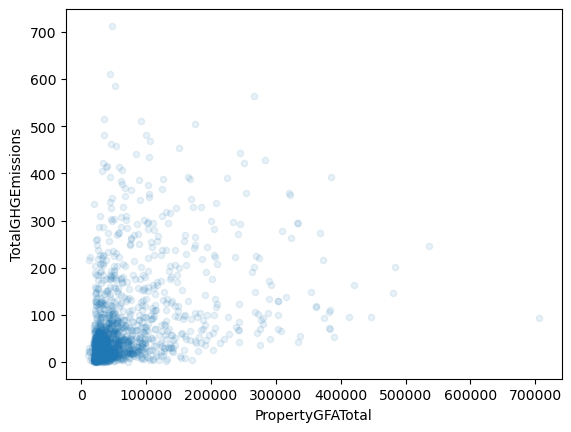

In [171]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='TotalGHGEmissions', alpha=0.1)

# Affichage du graphique
plt.show()

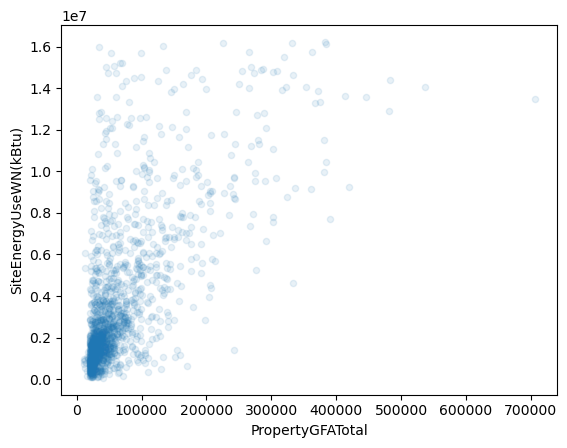

In [172]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Affichage du graphique
plt.show()

D'après ChatGPT, Un immeuble de bureaux de 700 000 pieds carrés correspondrait à un gratte-ciel ou à un immeuble de grande hauteur, typique des centres-villes ou des quartiers d'affaires majeurs.

Il est donc difficile de considérer les valeurs au-dessus de la limite haute comme aberrante.

Quel est le nombre d'étages du 700 000 ?

In [174]:
mask = data['PropertyGFATotal'] > 700000
print("Nombre d'étages des propriétés au-dessus de 700 000 :", data.loc[mask, 'NumberofFloors'].values)

Nombre d'étages des propriétés au-dessus de 700 000 : [6]


6 Etages c'est peu. Le bâtiment avec 700 000 de PropertyGFATotal est donc aberrant.

On le transform en NaN.

In [176]:
# remplacer dans le dataset
mask = data['PropertyGFATotal'] > 700000.
data.loc[mask, 'PropertyGFATotal'] = np.nan

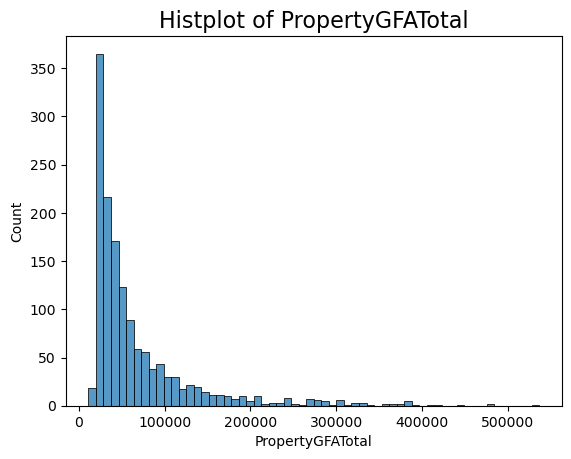

In [177]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

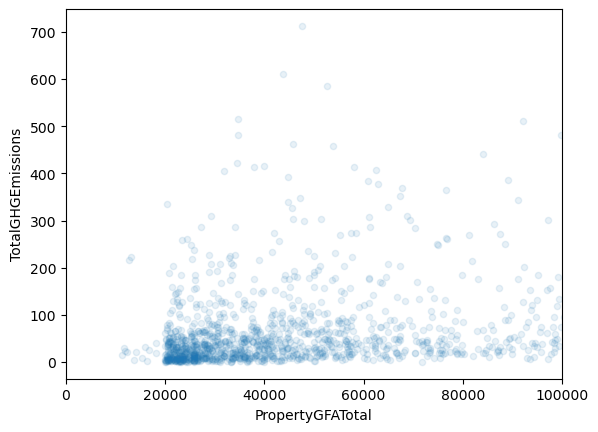

In [178]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='TotalGHGEmissions', alpha=0.1)

# Définir les limites de l'axe x
plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

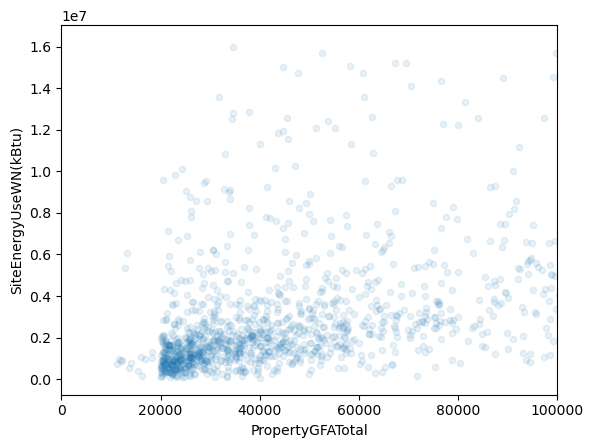

In [179]:
# Création du scatter plot
data.plot.scatter(x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Définir les limites de l'axe x
plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes:**

Identifier les valeurs manquantes :

In [181]:
mask = data['PropertyGFATotal'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 1


Il y a une valeur NaN. Quelles sont les caractéristiques de cette propriété ?

In [183]:
print(data.loc[mask])

      OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
2835          27145      2016  NonResidential        Large Office   

                        PropertyName      Address     City State  ZipCode  \
2835  719 2nd Ave (Millennium Tower)  719 2nd Ave  Seattle    WA  98104.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
2835                    5530510000                    7     DOWNTOWN   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
2835  47.60331 -122.33389       2000                1.0               6   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
2835               NaN                   0                  706176   

         ListOfAllPropertyUseTypes LargestPropertyUseType  \
2835  Bank Branch, Office, Parking                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
2835                   222807.0                      Parking   

      SecondLarge

Elle a 1 bâtiment et 6 étages. Quelle est la distribution de cette catégorie ?

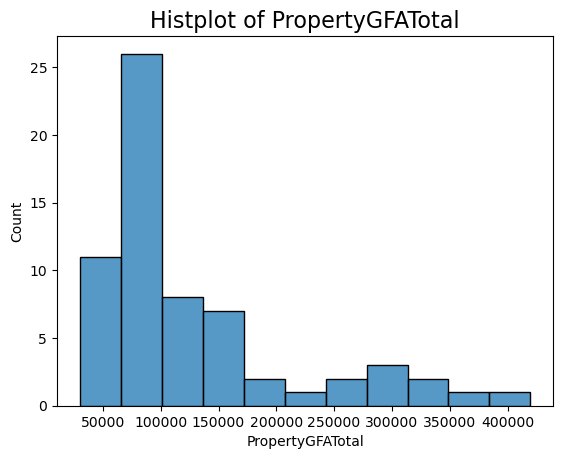

In [185]:
mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
sns.histplot(data=data.loc[mask], x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

Comme la distribution est asymétrique, je propose de remplacer le Nan par la médiane de cette catégorie.

In [187]:
# Calculer la médiane
mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
median = data.loc[mask, 'PropertyGFATotal'].median()
print("mediane = ", str(median))

mediane =  95740.5


In [188]:
mask = data['PropertyGFATotal'].isna()
data.loc[mask, 'PropertyGFATotal'] = median

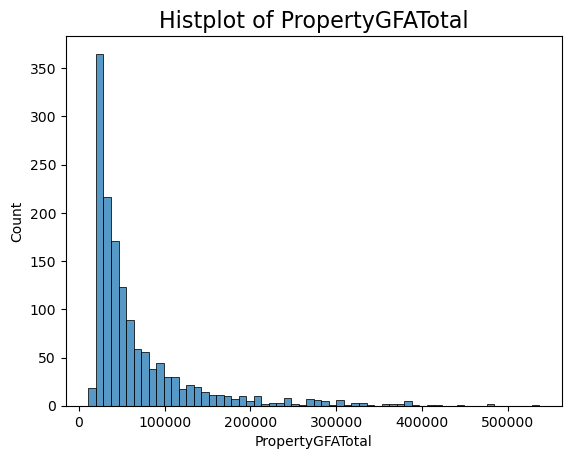

In [189]:
sns.histplot(data=data, x='PropertyGFATotal')
plt.title('Histplot of PropertyGFATotal', fontsize=16)
plt.show()

Identifier les valeurs nulles :

In [191]:
mask = data['PropertyGFATotal'] == 0
print("Nombre de valeurs nulles :", data.loc[mask].shape[0])

Nombre de valeurs nulles : 0


Il n'y a pas de valeurs nulles.

In [193]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,68869.966413,2.494647e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,68751.053439,2.744379e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.783500e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.357482e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,536697.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.8 - Nettoyer les données de la feature Electricity(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

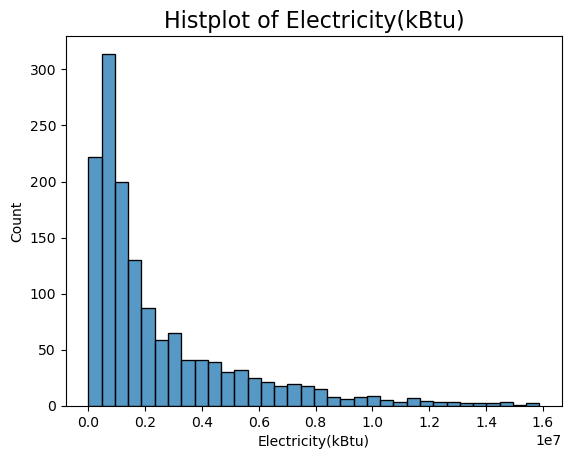

In [195]:
sns.histplot(data=data, x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu)', fontsize=16)
plt.show()

Distribution unimodale, asymétrique, avec étalement à droite. 

D'après ChatGPT :
- Les immeubles de bureaux consomment souvent entre 1 et 10 millions de kBtu par an, selon leur taille et leur utilisation.
- Des bâtiments très énergivores (comme les centres commerciaux, les hôpitaux, ou les data centers) peuvent atteindre 10 à 50 millions de kBtu par an, voire plus.

Tous les bâtiments doivent avoir une consommation électrique non nulle, car ils consomment nécessairement de l'electricité, ne serait-ce que pour l'éclairage. Combien de propriété consomme 0 kBtu d'électricité :

In [197]:
mask = data['Electricity(kBtu)'] == 0
print("Nombre de propriétés avec 0 kBtu de consommation électrique :", data.loc[mask].shape[0])

Nombre de propriétés avec 0 kBtu de consommation électrique : 1


In [198]:
print(data.loc[mask])

     OSEBuildingID  DataYear    BuildingType PrimaryPropertyType PropertyName  \
426          23854      2016  NonResidential          Restaurant      Pier 57   

              Address     City State  ZipCode TaxParcelIdentificationNumber  \
426  1301 Alaskan Way  Seattle    WA  98101.0                    7666202435   

     CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
426                    7     DOWNTOWN  47.60613 -122.34115       1900   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
426                1.0               1           43728.0                   0   

     PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
426                   43728                Restaurant             Restaurant   

     LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
426                    43728.0                          NaN   

     SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
426           

On transforme les valeurs 0 en NaN :

In [200]:
# remplacer dans le dataset
mask = data['Electricity(kBtu)'] == 0
data.loc[mask, 'Electricity(kBtu)'] = np.nan

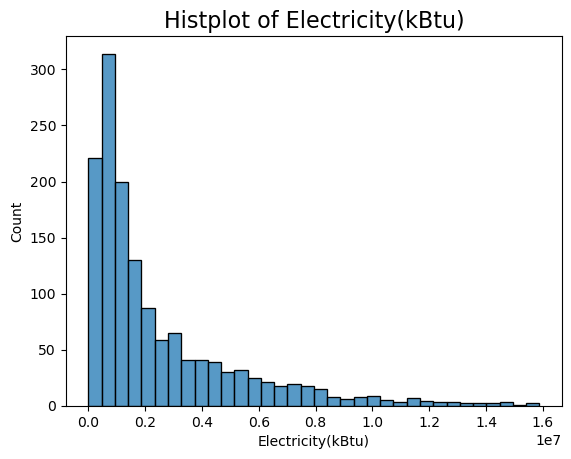

In [201]:
sns.histplot(data=data, x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu)', fontsize=16)
plt.show()

Visualiser les corréaltions éventuelles avec les cibles :

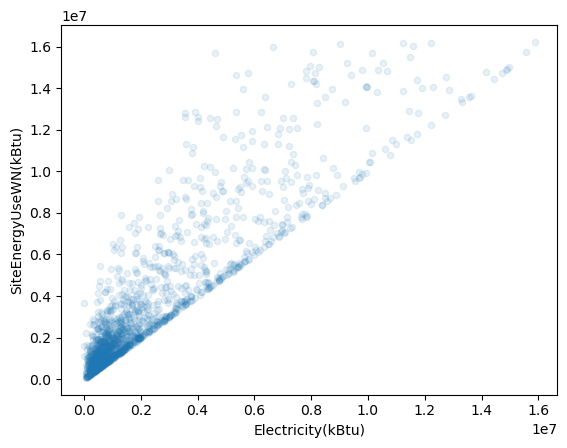

In [203]:
# Création du scatter plot
data.plot.scatter(x='Electricity(kBtu)', y='SiteEnergyUseWN(kBtu)', alpha=0.1)

# Définir les limites de l'axe x
#plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

Il n'y a pas de points sous la diagonale dans ce graphique car la consommation totale d'énergie d'un site (Site Energy Use WN), représentée sur l'axe 𝑦, inclut nécessairement la consommation d'électricité (Electricity), représentée sur l'axe 𝑥.

On observe une tendance linéaire claire où la consommation totale d’énergie du site augmente avec la consommation d’électricité (corrélation positive).
Cela indique que l’électricité constitue probablement une part importante de la consommation énergétique totale. Les deux variables sont fortement liées.

Les points proches de la diagonale suggèrent que, l’électricité représente une proportion majeure de la consommation énergétique totale (peut-être 100 %, ou presque).

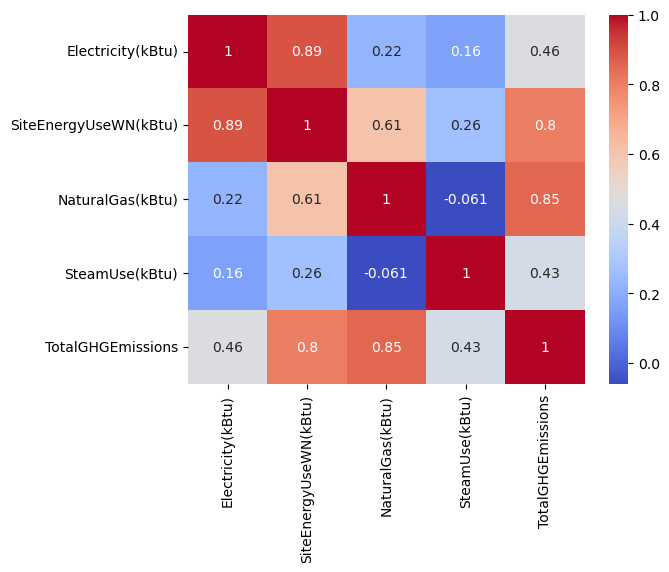

In [205]:
correlation_matrix = data[['Electricity(kBtu)', 'SiteEnergyUseWN(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'TotalGHGEmissions']].corr()

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Afficher la heatmap
plt.show()

L'observation est confirmée par le calcul du coefficient de corrélation entre la consommation électrique et la consommation totale.

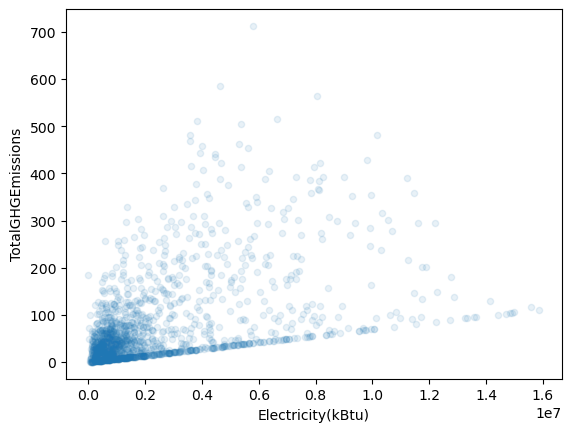

In [207]:
# Création du scatter plot
data.plot.scatter(x='Electricity(kBtu)', y='TotalGHGEmissions', alpha=0.1)

# Définir les limites de l'axe x
#plt.xlim(0, 100000)

# Affichage du graphique
plt.show()

**Traiter les valeurs manquantes**

In [209]:
mask = data['Electricity(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 1


Quel est le type de propriété ?

In [211]:
print("Type de propriété :", data.loc[mask, 'PrimaryPropertyType'])

Type de propriété : 426    Restaurant
Name: PrimaryPropertyType, dtype: object


Visualiser la distribution des propriétés de type "Restaurant"

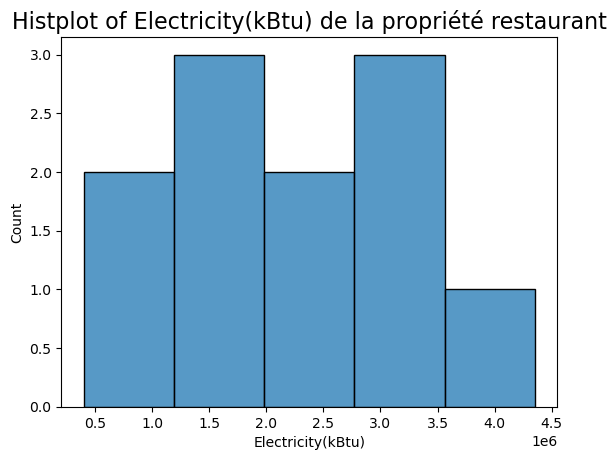

In [213]:
mask = data['PrimaryPropertyType'] == 'Restaurant'
sns.histplot(data= data.loc[mask], x='Electricity(kBtu)')
plt.title('Histplot of Electricity(kBtu) de la propriété restaurant', fontsize=16)
plt.show()

Je propose de remplacer le NaN par la moyenne :

In [215]:
# Calculer la moyenne des restaurants
mask = data['PrimaryPropertyType'] == 'Restaurant'
mean = data.loc[mask, 'Electricity(kBtu)'].mean()
print("moyenne = ", str(mean))

moyenne =  2177533.4545454546


In [216]:
mask = data['Electricity(kBtu)'].isna()
data.loc[mask, 'Electricity(kBtu)'] = mean

In [217]:
mask = data['Electricity(kBtu)'].isna()
print(data.loc[mask].shape[0])

0


In [218]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,68869.966413,2.496155e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,68751.053439,2.743606e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,3.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.785962e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.358182e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,536697.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.9 - Nettoyer les données de la feature NaturalGas(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

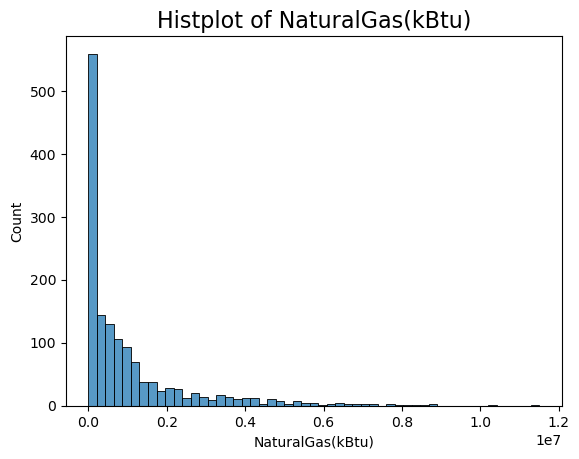

In [220]:
sns.histplot(data=data, x='NaturalGas(kBtu)')
plt.title('Histplot of NaturalGas(kBtu)', fontsize=16)
plt.show()

La distribution est unimodale, asymétrique, avec étalement à droite. Le nombre important de valeurs nulles s'explique par le fait que beaucoup de bâtiments ne sont pas nécessairement ratacchés au gaz.

D'après ChatGPT : 
"
Je ne dispose pas de chiffres précis et récents pour cette question spécifique, mais des rapports de la ville de Seattle indiquent souvent des tendances générales :

- Seattle est connue pour son engagement envers les énergies renouvelables et la réduction des combustibles fossiles.
- Une proportion significative des bâtiments utilise l'électricité, notamment grâce à la production hydroélectrique qui domine l'approvisionnement en électricité de Seattle.
- La ville a des objectifs ambitieux de réduction des émissions de carbone, ce qui a incité certains bâtiments à abandonner le gaz naturel pour passer à des sources d'énergie plus propres, notamment l'électricité.
"

Les valeurs nulles ne peuvent donc pas être considérées comme aberrantes.

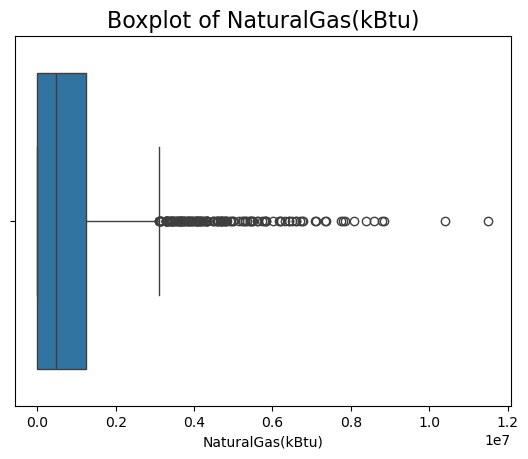

In [382]:
sns.boxplot(x=sample['NaturalGas(kBtu)'])
plt.title('Boxplot of NaturalGas(kBtu)', fontsize=16)
plt.show()

Quelles sont les types de propriétés des bâtiments de plus de 0,8 * 1e7 kBtu ?

In [389]:
mask = data['NaturalGas(kBtu)'] > 0.8 * 1e7
print("Nombre de bâtiments concernés :", data.loc[mask].shape[0])

print("Liste des types de propriétés correspondantes :", data.loc[mask, 'PrimaryPropertyType'].unique())

Nombre de bâtiments concernés : 7
Liste des types de propriétés correspondantes : ['Hotel' 'Mixed Use Property' 'Restaurant' 'Senior Care Community' 'Other']


Rechercher les outliers par la méthode inter quartile IQR :

In [392]:
# On calcule l'IQR (intervalle interquartile)
Q1 = data['NaturalGas(kBtu)'].quantile(0.25)
Q3 = data['NaturalGas(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kBtu")
print("limite haute :", round(limite_haute,2), "kBtu")

limite basse : 0 kBtu
limite haute : 3098502.5 kBtu


In [400]:
mask = data['NaturalGas(kBtu)'] > limite_haute
print("Nombre de bâtiments au-dessus la limite haute :", data.loc[mask].shape[0])

Nombre de bâtiments au-dessus la limite haute : 140


In [396]:
print("Liste des types de propriétés correspondantes :", data.loc[mask, 'PrimaryPropertyType'].unique())

Liste des types de propriétés correspondantes : ['Hotel' 'Other' 'University' 'K-12 School' 'Mixed Use Property'
 'Warehouse' 'Retail Store' 'Large Office' 'Supermarket / Grocery Store'
 'Laboratory' 'Distribution Center' 'Small- and Mid-Sized Office'
 'Restaurant' 'Medical Office' 'Senior Care Community' 'Worship Facility']


Je ne pense que l'IQR soit pertinent ici, car la consommation de gaz différe beaucoup selon l'utilisation de la propriété. Par exemple la forte consommation de gaz n'est pas aberrante pour les grands hôtels, et pour les restaurants.

Je ne considère donc pas ces valeurs comme aberrantes. En effet il faudrait étudier chaque propriété, une à une, ce qui prendrait trop de temps, ne serait pas forcément pertinent pour un 1er feature engineering.

**Traiter les valeurs manquantes**

In [403]:
mask = data['NaturalGas(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y a pas de valeurs manquantes ici.

In [461]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,68869.966413,2.496155e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,68751.053439,2.743606e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,3.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.785962e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.358182e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,536697.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.10 - Nettoyer les données de la feature SteamUse(kBtu)

**Traiter les valeurs aberrantes**

Visualiser la distribution :

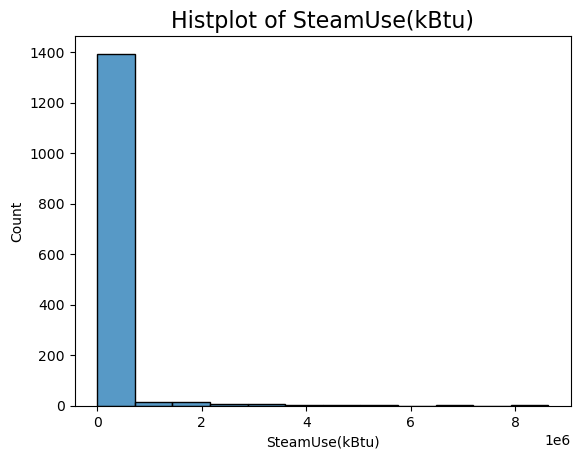

In [410]:
sns.histplot(data=data, x='SteamUse(kBtu)')
plt.title('Histplot of SteamUse(kBtu)', fontsize=16)
plt.show()

La distribution est unimodale, asymétrique. Le pic à 0 s'explique par une faible utilisation de la vapeur comme source d'énergie.

D'après ChatGPT, une consommation de 8 millions de kBtu ne serait pas aberrante. D'où dépend de l'usage du bâtiment. Je ne considère donc pas les valeurs élevées comme aberrantes à ce stade du projet. En effet il faudrait étudier chaque propriété, une à une, ce qui prendrait trop de temps, ne serait pas forcément pertinent pour un 1er feature engineering.

**Traiter les valeurs manquantes**

In [415]:
mask = data['SteamUse(kBtu)'].isna()
print("Nombre de valeurs manquantes :", data.loc[mask].shape[0])

Nombre de valeurs manquantes : 0


Il n'y a pas de valeurs manquantes.

In [463]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,68869.966413,2.496155e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,68751.053439,2.743606e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,3.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.785962e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.358182e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,536697.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


#### 6.11 - Sauvegarder le dataset nettoyé

In [429]:
data.to_csv('C:/Users/admin/Documents/Projets/Projet_4/data_projet/cleaned/2016_Building_Energy_Benchmarking_cleaned.csv', index=False)

#### 6.12 - Automatisation du nettoyage réalisé

Créer la fonction de nettoyage :

In [506]:
def clean(data):
    
    # SiteEnergyUseWN(kBtu)
    
    ## On calcule l'IQR (intervalle interquartile)
    Q1 = data['SiteEnergyUseWN(kBtu)'].quantile(0.25)
    Q3 = data['SiteEnergyUseWN(kBtu)'].quantile(0.75)
    IQR = Q3 - Q1
    
    ## On calcule les limites
    limite_basse = max(0, Q1 - 1.5 * IQR)
    limite_haute = Q3 + 1.5 * IQR
    
    ## Suppression des valeurs au-dessus de la limite haute
    mask = data['SiteEnergyUseWN(kBtu)'] <= limite_haute
    data = data.loc[mask]
    
    # TotalGHGEmissions
    
    ## Suppression des valeurs négatives
    mask = data['TotalGHGEmissions'] >= 0
    data = data.loc[mask]
    
    # YearBuilt - pas de besoin
    
    ## NumberofBuildings
    
    ## remplacer les valeurs nulles dans le dataset
    mask = data['NumberofBuildings'] == 0.
    data.loc[mask, 'NumberofBuildings'] = np.nan
    
    ## remplacer les valeurs manquantes par 1 qui est la valeur majoritaire
    mask = data['NumberofBuildings'].isna()
    data.loc[mask, 'NumberofBuildings'] = 1
    
    # NumberofFloors - pas de besoin
    
    # PropertyGFATotal
    
    ## remplacer dans le dataset
    mask = data['PropertyGFATotal'] > 700000.
    data.loc[mask, 'PropertyGFATotal'] = np.nan
    
    ## Calculer la médiane pour remplacer les valeurs manquantes par la médiane
    mask = (data['NumberofFloors'] == 6) & (data['NumberofBuildings'] == 1.0)
    median = data.loc[mask, 'PropertyGFATotal'].median()
        
    mask = data['PropertyGFATotal'].isna()
    data.loc[mask, 'PropertyGFATotal'] = median
    
    # Electricity(kBtu)
    
    ## remplacer dans le dataset
    mask = data['Electricity(kBtu)'] == 0
    data.loc[mask, 'Electricity(kBtu)'] = np.nan
    
    ## Calculer la moyenne des restaurants
    mask = data['PrimaryPropertyType'] == 'Restaurant'
    mean = data.loc[mask, 'Electricity(kBtu)'].mean()
        
    mask = data['Electricity(kBtu)'].isna()
    data.loc[mask, 'Electricity(kBtu)'] = mean
    
    # NaturalGas(kBtu) - pas de besoin
    
    # SteamUse(kBtu) - pas de besoin
    
    return data

On peut rejouer tout ce qui a été fait depuis le début :

In [508]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)

In [510]:
data = select_dataset(data)

In [512]:
data = delete_outliers(data)

In [514]:
data = clean(data)

In [516]:
data.shape

(1444, 46)

In [520]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

In [522]:
data[features_fe1].describe()

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions
count,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03,1.444000e+03,1.444000e+03,1.444000e+03,1444.000000
mean,1960.173823,1.052632,3.076177,68869.966413,2.496155e+06,1.018981e+06,9.458109e+04,3.770361e+06,78.809848
std,32.659878,0.395750,3.746620,68751.053439,2.743606e+06,1.505434e+06,5.618755e+05,3.595094e+06,95.626523
min,1900.000000,1.000000,0.000000,11285.000000,3.000000e+00,0.000000e+00,0.000000e+00,5.811420e+04,0.400000
25%,1929.000000,1.000000,1.000000,28062.000000,6.785962e+05,0.000000e+00,0.000000e+00,1.259692e+06,18.627500
50%,1963.000000,1.000000,2.000000,43653.000000,1.358182e+06,4.783005e+05,0.000000e+00,2.343374e+06,43.540000
75%,1987.000000,1.000000,4.000000,78380.750000,3.331490e+06,1.239401e+06,0.000000e+00,5.206862e+06,95.877500
max,2015.000000,6.000000,99.000000,536697.000000,1.587869e+07,1.150804e+07,8.630381e+06,1.622816e+07,712.390000


In [524]:
data[features_fe1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 0 to 3375
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PrimaryPropertyType    1444 non-null   object 
 1   Neighborhood           1444 non-null   object 
 2   YearBuilt              1444 non-null   int64  
 3   NumberofBuildings      1444 non-null   float64
 4   NumberofFloors         1444 non-null   int64  
 5   PropertyGFATotal       1444 non-null   float64
 6   Electricity(kBtu)      1444 non-null   float64
 7   NaturalGas(kBtu)       1444 non-null   float64
 8   SteamUse(kBtu)         1444 non-null   float64
 9   SiteEnergyUseWN(kBtu)  1444 non-null   float64
 10  TotalGHGEmissions      1444 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 135.4+ KB


#### 6.11 - Filtrer les features

Liste des features :

In [526]:
features_fe1 = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']

In [546]:
X_fe1 = data[features_fe1].copy()
X_fe1.head()

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
0,Hotel,DOWNTOWN,1927,1.0,12,88434.0,3946027.0,1276453.0,2003882.00
1,Hotel,DOWNTOWN,1996,1.0,11,103566.0,3242851.0,5145082.0,0.00
3,Hotel,DOWNTOWN,1926,1.0,10,61320.0,2768924.0,1811213.0,2214446.25
4,Hotel,DOWNTOWN,1980,1.0,18,175580.0,5368607.0,8803998.0,0.00
5,Other,DOWNTOWN,1999,1.0,2,97288.0,7371434.0,4715182.0,0.00


#### 6.12 - Extraire les 2 cibles

In [530]:
y_fe1_conso = data['SiteEnergyUseWN(kBtu)']
y_fe1_conso.shape

(1444,)

In [532]:
y_fe1_emission = data['TotalGHGEmissions']
y_fe1_emission.shape

(1444,)

#### 6.12 - Transformer la feature YearBuilt en feature par plage de date

Visualier la distribution :

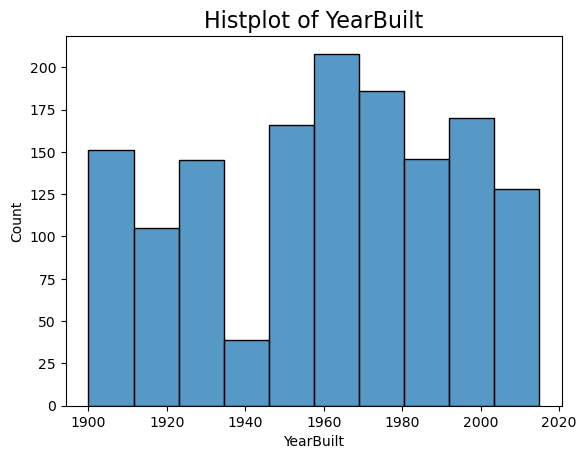

In [534]:
sns.histplot(data=data, x='YearBuilt', bins=10)
plt.title('Histplot of YearBuilt', fontsize=16)
plt.show()

In [548]:
# Créer 5 bins automatiques
X_fe1['YearBuilt_Bin'] = pd.cut(X_fe1['YearBuilt'], bins=10)

In [550]:
X_fe1.head()

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),YearBuilt_Bin
0,Hotel,DOWNTOWN,1927,1.0,12,88434.0,3946027.0,1276453.0,2003882.00,"(1923.0, 1934.5]"
1,Hotel,DOWNTOWN,1996,1.0,11,103566.0,3242851.0,5145082.0,0.00,"(1992.0, 2003.5]"
3,Hotel,DOWNTOWN,1926,1.0,10,61320.0,2768924.0,1811213.0,2214446.25,"(1923.0, 1934.5]"
4,Hotel,DOWNTOWN,1980,1.0,18,175580.0,5368607.0,8803998.0,0.00,"(1969.0, 1980.5]"
5,Other,DOWNTOWN,1999,1.0,2,97288.0,7371434.0,4715182.0,0.00,"(1992.0, 2003.5]"


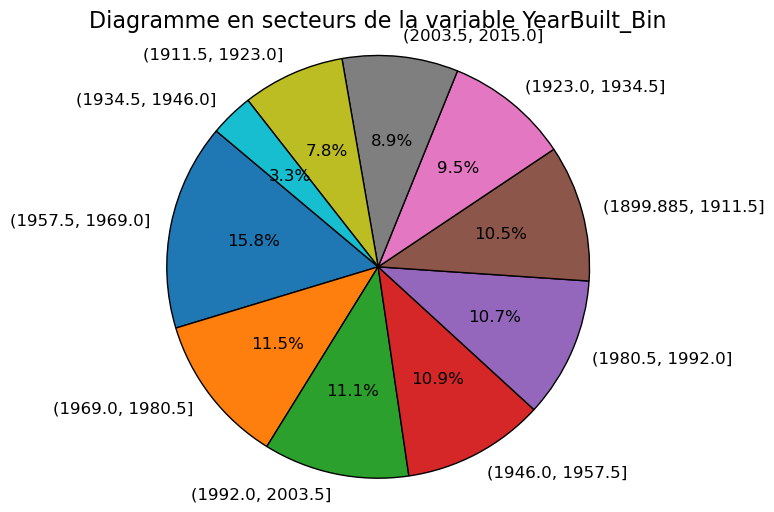

In [554]:
build_pieplot(X_fe1['YearBuilt_Bin'].value_counts(), 'YearBuilt_Bin')

#### 6.13 - Numériser les variables catégorielles PrimaryPropertyType, Neighborhood et YearBuilt_Bin

On va utiliser le oneHotEncoding pour le 1er feature engineering

In [563]:
# Initialiser l'encodeur
encoder = OneHotEncoder()

# Appliquer l'encodeur à une colonne spécifique
columns = ['PrimaryPropertyType', 'Neighborhood', 'YearBuilt_Bin']
encoded_columns = encoder.fit_transform(X_fe1[columns])

# Ajouter les colonnes encodées dans le DataFrame original
encoded_X_fe1 = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(columns))
X_fe1 = pd.concat([X_fe1, encoded_X_fe1], axis=1)

In [565]:
X_fe1.head()

,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu),YearBuilt_Bin,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_Hospital,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Laboratory,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Medical Office,PrimaryPropertyType_Mixed Use Property,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Refrigerated Warehouse,PrimaryPropertyType_Residence Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail Store,PrimaryPropertyType_Self-Storage Facility,PrimaryPropertyType_Senior Care Community,PrimaryPropertyType_Small- and Mid-Sized Office,PrimaryPropertyType_Supermarket / Grocery Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,Neighborhood_BALLARD,Neighborhood_Ballard,Neighborhood_CENTRAL,Neighborhood_Central,Neighborhood_DELRIDGE,Neighborhood_DELRIDGE NEIGHBORHOODS,Neighborhood_DOWNTOWN,Neighborhood_Delridge,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,"YearBuilt_Bin_(1899.885, 1911.5]","YearBuilt_Bin_(1911.5, 1923.0]","YearBuilt_Bin_(1923.0, 1934.5]","YearBuilt_Bin_(1934.5, 1946.0]","YearBuilt_Bin_(1946.0, 1957.5]","YearBuilt_Bin_(1957.5, 1969.0]","YearBuilt_Bin_(1969.0, 1980.5]","YearBuilt_Bin_(1980.5, 1992.0]","YearBuilt_Bin_(1992.0, 2003.5]","YearBuilt_Bin_(2003.5, 2015.0]"
0,Hotel,DOWNTOWN,1927.0,1.0,12.0,88434.0,3946027.0,1276453.0,2003882.00,"(1923.0, 1934.5]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hotel,DOWNTOWN,1996.0,1.0,11.0,103566.0,3242851.0,5145082.0,0.00,"(1992.0, 2003.5]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Hotel,DOWNTOWN,1926.0,1.0,10.0,61320.0,2768924.0,1811213.0,2214446.25,"(1923.0, 1934.5]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,Hotel,DOWNTOWN,1980.0,1.0,18.0,175580.0,5368607.0,8803998.0,0.00,"(1969.0, 1980.5]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,Other,DOWNTOWN,1999.0,1.0,2.0,97288.0,7371434.0,4715182.0,0.00,"(1992.0, 2003.5]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
